Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "Tang Han"
COLLABORATORS = ""

---

# Lab 10: Use Bootstrap to Estimate Mean and Variance

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## Due Date

This assignment is due at 11:59pm Monday, November 5th.

## Introduction

In this lab, you will examine the bootstrap in greater detail. The goal is to develop a functional approach to bootstrapping any statistic for any sample.


## Collaborators  

Write names in this cell:

In [3]:
# Run this cell to set up your notebook

import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from IPython.display import display, Latex, Markdown


## The Bootstrap Procedure

The bootstrap is a very simple process: 
* Sample with replacement from the original sample (now the **bootstrap population**). These samples are called **bootstrap samples**. We typically take thousands of bootstrap samples (~10,000 is common).
* Calculate the statistic of interest for each bootstrap sample. This statistic is called the **bootstrap statistic**, and the empirical distribution of these bootstrap statistics is an approximation to the **sampling distribution** of the bootstrapped statistic.

But why bootstrap instead of just calculating the statistic of interest once on the whole sample? 

Take sample mean estimator as an example. Suppose $\{x_i\}$ are samples coming from an unknown distribution. We can use sample mean $\bar{X} = \frac{1}{n}\sum_{i=1}^n x_i$ to estimate the the mean of the population. However, if we obtain another sample set $\{x_i\}$, we can get very different results. Therefore, computing the sampling distribution (distribution of the sample mean for all possible sample sets) would be very helpful. From such distribution, we can also obtain the bias of this estimator: $E (\bar{X}) - \mu$, and the variance of the estimator: $E[E(\bar{X})-\bar{X}]^2$.

In order to compute the sampling distribution of $\bar{X}$, we could directly use sampling methods. But that requires us to obtain several different sets of samples $\{x_i\}$ directly from the population. If we have $m$ sets of samples and each set contains $n$ subjects (totaling $m*n$ subjects), we can then use $ \hat{X} = \frac{1}{m}\sum_{j=1}^m \bar{X_j}$ to approximate $E(\bar{X})$, and $\frac{1}{m}\sum_{j=1}^m (\hat{X} - \bar{X_j})^2$ to approximate $E[E(\bar{X})-\bar{X}]^2$.

However, in reality, this is often unfeasible, and we only have one set of samples (**bootstrap population**). Therefore we can use bootstrap method to resample (sample with replacement) from the **bootstrap population** to obtain $m$ different **bootstrap samples**, each **bootstrap sample** has the same amount of data as in **bootstrap population**.

Why do we sample with replacement?
Recall that we are trying to mimic the ideal scenario of directly sampling from the original population. In the case where each bootstrap sample has the same amount of data as the bootstrap population, sampling without replacement would cause every bootstrap sample to be identical to the bootstrap population. Even when the bootstrap samples have less samples that the bootstrap population, sampling without replacement would cause the samples to be *based on the original sample*. Instead, sampling with replacement causes our bootstrap samples to be *based on the distribution of the original sample* (which we assume is representative of the original population).

## Pre-lab

### Question 0

Bootstrap samples should have the same amount of data as the bootstrap population when used to estimate the standard error, perform hypothesis testing, or construct confidence intervals. Otherwise, bootstrap samples just need to have an equal (and reasonable) amount of data. Why do you think bootstrap sample size needs to meet this additional restriction for these applications? Hint: look at the standard error formula.

Your answer in this block:

## Lab
Your task is to write a generic bootstrap procedure.

### Question 1
In today's lab, let's try to use bootstrap method to estimate the distribution of sample mean and sample standard deviation  of our midterm grades. You will be given a noisy sample of grades from this midterm, which is the **bootstrap population**. You should use **sampling with replacement** to resample from this dataset again and again to obtain **bootstrap samples** and compute the **bootstrap statistic**.

First, write your own sampling function. The function `simple_resample` samples with replacement from the integers 0 through *n-1* and returns an array of length *n*
with the sampled integers. That is, `simple_resample` produces the indices for
a single bootstrap replicate from the bootstrap population.

Use the `numpy.random.randint` function to do the random sampling. 


In [7]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1
    """
    # YOUR CODE HERE
#     raise NotImplementedError()
    return np.random.randint(low=0, high=n, size=n)  

simple_resample(10)

array([5, 8, 6, 1, 3, 9, 4, 4, 4, 9])

Try your `simple_resample` function on a few cases to see if the sampling looks right.

In [21]:
(1 - (999/1000)**1000) # probability of 42 in simple_resample(1000)

0.6323045752290363

In [22]:
(1 - (999/1000)**1000) * 100000 # expectation of sum of 100000 such Bernoulli random variables, which has Binomial distribution

63230.45752290363

In [23]:
np.sqrt(100000 * (1 - (999/1000)**1000) * ((999/1000)**1000))  # standard deviation

152.47803099904729

In [8]:
# chances are less than 5.8 in 10^20 that this test fails when the function is correct
assert (sum((42 in simple_resample(1000)) for _ in range(100000)) in range(63230-1500,63230+1500))
assert (len(simple_resample(1000)) == 1000)

### Question 2

Next let's write the function `bootstrap` which returns an array of length `replicates`, each entry being the `statistic` of interest computed on a bootstrap sample from the `boot_pop` (bootstrap population).

In our case, the `statistic` could be the `np.mean` and `np.std` function. And the `resample` could be `simple_resample`. Here we leave them as parameters so that we could switch to other statistic and resample functions.

For each bootstrap sample, you should first use `resample` to obtain samples from the `boot_pop`, then compute the statistic of those samples using the `statistic` method, and put it into your result.

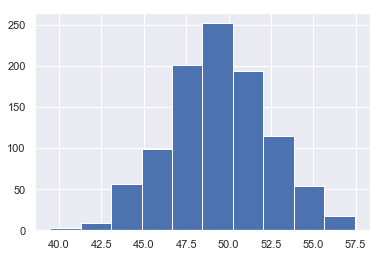

In [38]:
# My attempt
def bootstrap(boot_pop, statistic, resample, replicates=1000):
    """
    Args:
        boot_pop: an array of size n.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the intergers [0, n)
        replicates: the number of resamples
    """
    boot_stats = []
    n = boot_pop.shape[0]
    for _ in range(replicates):
        boot_sample = boot_pop[resample(n)]
        boot_stat = statistic(boot_sample)
        boot_stats.append(boot_stat)
    return np.array(boot_stats)

plt.hist(bootstrap(np.arange(100), np.mean, simple_resample));

In [ ]:
# Official method
def bootstrap(boot_pop, statistic, resample, replicates = 1000):
    """
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    # YOUR CODE HERE
#     raise NotImplementedError()
    ans = []
    for i in range(replicates):
        ans.extend([statistic(boot_pop[resample(boot_pop.shape[0])])])
    return np.array(ans)

In [34]:
assert (len(bootstrap(np.ones(10), np.mean, simple_resample)) == 1000)
assert (np.all(bootstrap(np.ones(10), np.mean, simple_resample, replicates = 1000) == np.ones(1000)))
# chances are less than 3.9 in 10^22 that this test fails when the function is correct
assert (sum(bootstrap(np.array([0,1]), np.median, simple_resample, replicates = 10000) == 0.5) in range(5000-500,5000+500))

Now let's use the bootstrap function to compute the distribution of the sample mean for the midterm grade.

First, let's load the data.

In [39]:
data = pd.read_csv("grades_sample.csv")
data.head()

,Grade
0,70.652174
1,85.418495
2,84.909697
3,55.759027
4,75.008190


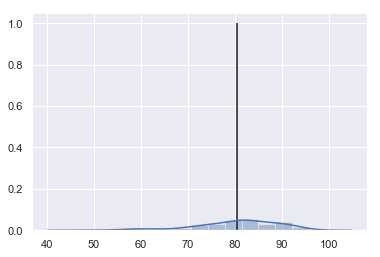

In [40]:
sns.distplot(data)
plt.vlines(np.mean(data),0,1);

Now use the right parameters to call our `bootstrap` method to obtain the sample mean $\bar{X}$ for $m$ different bootstrap samples $\{x_i\}$. 

In [47]:
m = 1000  # the number of resamples 
boot_pop = np.array(data["Grade"])

boot_sample_means = bootstrap(boot_pop, np.mean, simple_resample, replicates=m)

# YOUR CODE HERE
# raise NotImplementedError()

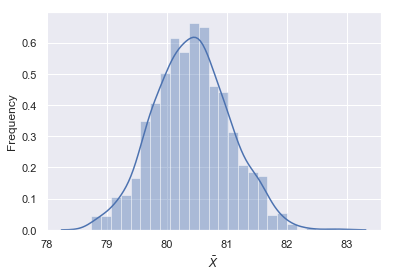

In [48]:
sns.distplot(boot_sample_means)
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");

In [49]:
boot_mean_mean = np.mean(boot_sample_means)
boot_var_mean = np.var(boot_sample_means)
print('mean of bootstrap mean:', boot_mean_mean, '\nvariance of bootstrap mean:', boot_var_mean)
assert len(boot_sample_means) == m
assert 80 < boot_mean_mean < 81
assert 0.3 < boot_var_mean < 0.5

mean of bootstrap mean: 80.416484889 
variance of bootstrap mean: 0.396284638376


Now use the right parameters to call our `bootstrap` method to obtain the standard deviation $\sqrt{\frac{1}{n}\sum_{i=1}^{n} (x_i-\bar{X})^2}$ for $m$ different bootstrap samples $\{x_i\}$. You should use `np.std`

In [50]:
m = 1000
boot_pop = np.array(data["Grade"])

boot_sample_std = bootstrap(boot_pop, np.std, simple_resample, replicates=m)

# YOUR CODE HERE
# raise NotImplementedError()

In [51]:
boot_mean_std = np.mean(boot_sample_std)
boot_var_std = np.var(boot_sample_std)
print('mean of bootstrap std:', boot_mean_std, '\nvariance of bootstrap std:', boot_var_std)
assert len(boot_sample_std) == m
assert 7 < boot_mean_std < 10
assert 0.23 < boot_var_std < 0.29

mean of bootstrap std: 8.70598980277 
variance of bootstrap std: 0.27018824492


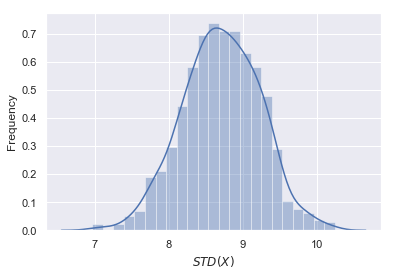

In [52]:
sns.distplot(boot_sample_std)
plt.xlabel(r"$STD(X)$")
plt.ylabel("Frequency");

The true mean for the midterm grade is 80.1, and the standard deviation is 9.20.
Compare your results with them.

### Question 3
Now let's use the bootstrap method to analyze an estimator we used in the previous lab. 

Again, we use following mathematical model to predict Tips from TotalBill:

$$\Large
\texttt{Tip} = \theta^*  \times \texttt{TotalBill}
$$

This follows the similar intuition that tips are some **unknown** percentage of the total bill.  We will then try to estimate the slope of this relationship which corresponds to the percent tip. Here the parameter $\theta^*$ represents the true percent tip that we would like to estimate.

As we already know, for L2 loss function:
$$\Large
L\left(\theta, \mathcal{D}\right) = \frac{1}{n} \sum_{i=1}^n L(m_\theta(x_i), y_i) = \frac{1}{n} \sum_{i=1}^n (\theta *  x_i - y_i)^2
$$

Where, $x_i$ is the TotalBill, $y_i$ is the Tips.

The optimal $\theta$ would be:
$$\Large {\theta} = \frac{\sum x_iy_i}{\sum x_i^2}$$

Let's use the bootstrap method to see what's the variance for this estimator.


In [70]:
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


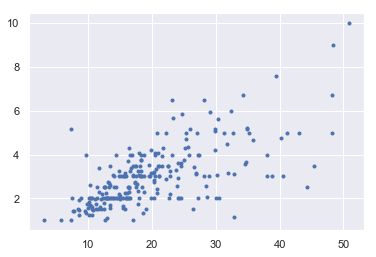

In [88]:
x = np.array(data["total_bill"])
y = np.array(data["tip"])
d = np.array((x,y)).transpose()
plt.plot(d[:,0],d[:,1],".");

Write an estimator function to compute $\theta$ using the formula:  
$$\large {\theta} = \frac{\sum x_iy_i}{\sum x_i^2}$$

Note that in order to do bootstrap, we need to combine `x`, `y` to into a $n \times 2$ array `d`. So `d[:,0]` is equivalent with `x` and `d[:,1]` is equivalent with `y`.

In [89]:
def estimator(d):
    """
    Args:
        d: A n*2 array which contains x and y. d[:,0] would be x, d[:,1] would be y.
        
    Returns:
        The optimal theta for this dataset under L2 loss.
    """
    # YOUR CODE HERE
#     raise NotImplementedError()
    return np.sum(d[:,0] * d[:, 1]) / np.sum(d[:, 0] ** 2)

In [90]:
assert np.isclose(estimator(d),0.14373189527721666)

Now let's use our previous `bootstrap` function to obtain different estimated $\theta$. You should use the `estimator` function as the `statistic` parameter.

In [91]:
replicates = 1000
boot_theta = bootstrap(d, estimator, simple_resample, replicates=replicates)

# YOUR CODE HERE
# raise NotImplementedError()

In [92]:
boot_theta_mean = np.mean(boot_theta)
boot_theta_var = np.var(boot_theta)
print('mean of bootstrap theta:', boot_theta_mean, '\nvariance of bootstrap theta:', boot_theta_var)
assert len(boot_theta) == replicates
assert 0.14<=boot_theta_mean<=0.15
assert boot_theta_var < 1e-4

mean of bootstrap theta: 0.143949770018 
variance of bootstrap theta: 1.82526854056e-05


Finally, let's plot the distribution of `boot_theta`.

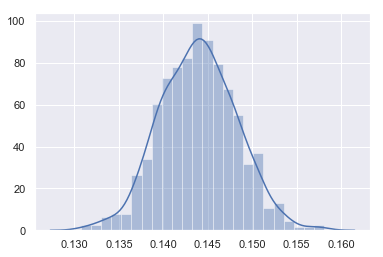

In [93]:
sns.distplot(boot_theta);

## Submission

Congrats! You are finished with this assignment. Please don't forget to submit by 11:59 pm!

## Submission

You're done!

Before submitting this assignment, ensure to:

1. Restart the Kernel (in the menubar, select Kernel->Restart & Run All)
2. Validate the notebook by clicking the "Validate" button

Finally, make sure to **submit** the assignment via the Assignments tab in Datahub